# Result Notebook

This note book contains the processing workflow how the model we trained can be applied.

All data preprocessing, model training and evaluation was done in the scripts found in the script directory.

# Packages

In [1]:
# Use autoreload to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import rootutils
root_path = rootutils.find_root()

In [3]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
from burned_embedder.classifier.dataset import create_datasets
from burned_embedder.classifier.model import get_model
from burned_embedder.classifier.model_utils import (
    train_epoch, evaluate, EarlyStopping, print_metrics
)

In [4]:

from burned_embedder.utils import setup_device
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, 
    confusion_matrix, average_precision_score
)

# Setting up data

Config for the classifier model. Note: model is not trained here - config is just for some metadata.

In [5]:
config = {
    'test_size': 0.2,
    'val_split': 0.1,
    'seed': 2,
    'input_type': 'concat',
    'hidden_dims': [1400, 700, 350],
    'dropout': 0.4,
    'weight_decay': 1e-4,
    'batch_size': 32,
    'lr': 0.001,
    'epochs': 100,
    'patience': 15,
}

Get the datasets and dataloaders that retrieve the computed embeddings.

In [6]:
# Setup device
device = setup_device(gpu_index=1, memory_fraction=1.0)
print(f"\nUsing device: {device}")

# Create datasets
print("\nCreating datasets...")
train_dataset, val_dataset, test_dataset = create_datasets(
    test_size=config['test_size'],
    val_split=config['val_split'],
    random_state=config['seed'],
    input_type=config['input_type'],
    augment=False  
)

# Get input dimension
sample_embedding, _ = train_dataset[0]
input_dim = sample_embedding.shape[0]
print(f"Input dimension: {input_dim}")

# Create dataloaders - reproducible same as for training
train_loader = DataLoader(
    train_dataset, 
    batch_size=config['batch_size'], 
    shuffle=True, 
    num_workers=4
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False, 
    num_workers=4
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False, 
    num_workers=4
)



Using device: cuda:1

Creating datasets...
Loaded 1556 positive samples
Loaded 1402 negative samples

Dataset splits:
  Train: 2129 samples (pos: 1120, neg: 1009)
  Val:   237 samples (pos: 125, neg: 112)
  Test:  592 samples (pos: 311, neg: 281)
  Input type: concat
Input dimension: 1536


For Southeast-Asia and Africa.

In [7]:
# Load Southeast Asia dataset
print("\nLoading Southeast Asia dataset...")
from burned_embedder.classifier.dataset import load_embedding_paths_and_labels, DeforestationDataset

def load_continent_dataset(continent_name, input_type='concat', batch_size=32):
    """Load dataset for a specific continent"""
    pos_paths, pos_labels = load_embedding_paths_and_labels('positive', continent=continent_name)
    neg_paths, neg_labels = load_embedding_paths_and_labels('negative', continent=continent_name)
    
    all_paths = pos_paths + neg_paths
    all_labels = pos_labels + neg_labels
    
    dataset = DeforestationDataset(
        all_paths, all_labels, 
        input_type=input_type, 
        normalize=True, 
        augment=False
    )
    
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4
    )
    
    print(f"{continent_name.replace('_', ' ').title()}: {len(dataset)} samples "
          f"(pos: {sum(all_labels)}, neg: {len(all_labels) - sum(all_labels)})")
    
    return dataloader, all_labels, all_paths

# Load Southeast Asia
sea_loader, sea_labels, sea_paths = load_continent_dataset(
    'southeast_asia',
    input_type=config['input_type'],
    batch_size=config['batch_size']
)

# Load Africa
africa_loader, africa_labels, africa_paths = load_continent_dataset(
    'africa',
    input_type=config['input_type'],
    batch_size=config['batch_size']
)


Loading Southeast Asia dataset...
Southeast Asia: 56 samples (pos: 29, neg: 27)
Africa: 34 samples (pos: 15, neg: 19)


# Load trained Deforestation Image-Level Classifier

# 

In [8]:
# Load the best trained model
model_path = root_path / "models" / "final_classifier" / "best_model.pt"
print(f"\nLoading trained model from: {model_path}")

checkpoint = torch.load(model_path, map_location=device)
print(f"Model trained for {checkpoint['epoch']} epochs")
print(f"Best validation F1: {checkpoint['val_f1']:.4f}")

# Get actual input dimension from checkpoint
first_layer_weight = checkpoint['model_state_dict']['model.0.weight']
actual_input_dim = first_layer_weight.shape[1]
print(f"Input dimension from checkpoint: {actual_input_dim}")

# Initialize model with correct architecture
model = get_model(
    input_dim=actual_input_dim,
    hidden_dims=config['hidden_dims'],
    dropout=config['dropout'],
    device=device
)

# Load trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded and ready for inference")


Loading trained model from: /net/home/lmaecker/own_projects/burned_embedder/models/final_classifier/best_model.pt
Model trained for 45 epochs
Best validation F1: 0.8638
Input dimension from checkpoint: 1536

Model Architecture:
DifferenceMLP(
  (model): Sequential(
    (0): Linear(in_features=1536, out_features=1400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=1400, out_features=700, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=700, out_features=350, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=350, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Total parameters: 3,378,201
Trainable parameters: 3,378,201
Model loaded and ready for inference


# Run predictions on all test samples

In [9]:
# Run predictions on test set
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, 
    confusion_matrix, average_precision_score
)

print(f"\n{'='*70}")
print("Running Predictions on Test Set")
print(f"{'='*70}")

model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for embeddings, labels in tqdm(test_loader, desc="Processing test batches"):
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        
        outputs = model(embeddings)
        preds = (outputs > 0.5).float()
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print(f"Processed {len(all_preds)} test samples")


Running Predictions on Test Set


Processing test batches:   0%|          | 0/19 [00:00<?, ?it/s]

Processing test batches: 100%|██████████| 19/19 [00:00<00:00, 65.11it/s]

Processed 592 test samples


For Southeast-Asia and Africa.

In [10]:
# Evaluate Southeast Asia
print("\nEvaluating Southeast Asia...")
sea_preds = []
sea_probs = []
model.eval()
with torch.no_grad():
    for embeddings, labels in tqdm(sea_loader, desc="Processing Southeast Asia"):
        embeddings = embeddings.to(device)
        outputs = model(embeddings)
        preds = (outputs > 0.5).float()
        sea_preds.extend(preds.cpu().numpy())
        sea_probs.extend(outputs.cpu().numpy())

sea_preds = np.array(sea_preds)
sea_probs = np.array(sea_probs)

# Evaluate Africa
print("\nEvaluating Africa...")
africa_preds = []
africa_probs = []
model.eval()
with torch.no_grad():
    for embeddings, labels in tqdm(africa_loader, desc="Processing Africa"):
        embeddings = embeddings.to(device)
        outputs = model(embeddings)
        preds = (outputs > 0.5).float()
        africa_preds.extend(preds.cpu().numpy())
        africa_probs.extend(outputs.cpu().numpy())

africa_preds = np.array(africa_preds)
africa_probs = np.array(africa_probs)


Evaluating Southeast Asia...


Processing Southeast Asia:   0%|          | 0/2 [00:00<?, ?it/s]

Processing Southeast Asia: 100%|██████████| 2/2 [00:00<00:00, 14.90it/s]



Evaluating Africa...


Processing Africa: 100%|██████████| 2/2 [00:00<00:00, 13.68it/s]


# Validation Results

In [11]:
# Calculate metrics
f1 = f1_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
roc_auc = roc_auc_score(all_labels, all_probs)
avg_precision = average_precision_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)

# Error rates
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

In [12]:
# Print detailed results (same format as 08_create_val_report.py)
print(f"\n{'='*70}")
print("Test Set Performance")
print(f"{'='*70}")

print(f"\nClassification Metrics:")
print(f"  F1 Score:       {f1:.4f}")
print(f"  Precision:      {precision:.4f}")
print(f"  Recall:         {recall:.4f}")
print(f"  ROC-AUC:        {roc_auc:.4f}")
print(f"  Avg Precision:  {avg_precision:.4f}")

print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Neg    Pos")
print(f"  Actual Neg [{cm[0,0]:4d}  {cm[0,1]:4d}]")
print(f"         Pos [{cm[1,0]:4d}  {cm[1,1]:4d}]")

print(f"\nError Analysis:")
print(f"  False Positive Rate: {fpr:.4f} ({fp}/{fp+tn})")
print(f"  False Negative Rate: {fnr:.4f} ({fn}/{fn+tp})")

print(f"\nSample Distribution:")
print(f"  Total Samples: {len(all_labels)}")
print(f"  Positive: {tp + fn}")
print(f"  Negative: {tn + fp}")


Test Set Performance

Classification Metrics:
  F1 Score:       0.8704
  Precision:      0.8662
  Recall:         0.8746
  ROC-AUC:        0.9382
  Avg Precision:  0.9403

Confusion Matrix:
                Predicted
              Neg    Pos
  Actual Neg [ 239    42]
         Pos [  39   272]

Error Analysis:
  False Positive Rate: 0.1495 (42/281)
  False Negative Rate: 0.1254 (39/311)

Sample Distribution:
  Total Samples: 592
  Positive: 311
  Negative: 281


/tmp/ipykernel_2284483/397293728.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


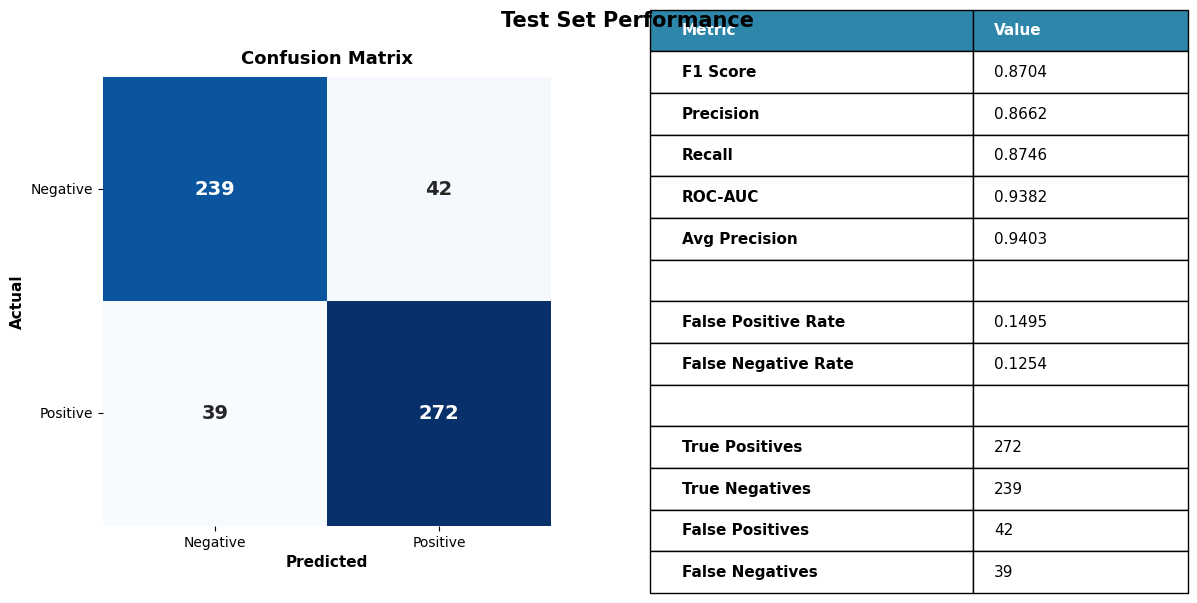

In [13]:
# Visualize confusion matrix and metrics (same style as 08_create_val_report.py)
import seaborn as sns

fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2], hspace=0.3)

# Confusion Matrix
ax1 = fig.add_subplot(gs[0])
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=ax1,
    cbar=False,
    square=True,
    annot_kws={'size': 14, 'weight': 'bold'}
)
ax1.set_title('Confusion Matrix', fontsize=13, fontweight='bold', pad=10)
ax1.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax1.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax1.set_xticklabels(['Negative', 'Positive'], fontsize=10)
ax1.set_yticklabels(['Negative', 'Positive'], fontsize=10, rotation=0)

# Metrics table
ax2 = fig.add_subplot(gs[1])
ax2.axis('tight')
ax2.axis('off')

metrics_data = [
    ['Metric', 'Value'],
    ['F1 Score', f"{f1:.4f}"],
    ['Precision', f"{precision:.4f}"],
    ['Recall', f"{recall:.4f}"],
    ['ROC-AUC', f"{roc_auc:.4f}"],
    ['Avg Precision', f"{avg_precision:.4f}"],
    ['', ''],
    ['False Positive Rate', f"{fpr:.4f}"],
    ['False Negative Rate', f"{fnr:.4f}"],
    ['', ''],
    ['True Positives', f"{tp}"],
    ['True Negatives', f"{tn}"],
    ['False Positives', f"{fp}"],
    ['False Negatives', f"{fn}"],
]

table = ax2.table(
    cellText=metrics_data,
    cellLoc='left',
    loc='center',
    colWidths=[0.6, 0.4]
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header row
for i in range(2):
    table[(0, i)].set_facecolor('#2E86AB')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style metric rows
for i in range(1, len(metrics_data)):
    if metrics_data[i][0] == '':
        continue
    table[(i, 0)].set_text_props(weight='bold')

plt.suptitle('Test Set Performance', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Sample Visualization

In [14]:
# Update the categorize_predictions function to handle the correct attribute name
def categorize_predictions(preds, probs, labels, paths, continent_name):
    """
    Categorize predictions into TP, FP, TN, FN with event IDs
    """
    results = {
        'true_positives': [],
        'false_positives': [],
        'true_negatives': [],
        'false_negatives': []
    }
    
    for i, (pred, prob, label, path) in enumerate(zip(preds, probs, labels, paths)):
        # Extract event_id from path
        # path is tuple of (before_path, after_path)
        event_id = int(path[0].parent.name.split('_')[1])
        
        item = {
            'event_id': event_id,
            'prediction': pred,
            'probability': prob,
            'label': label,
            'continent': continent_name
        }
        
        if label == 1 and pred == 1:
            results['true_positives'].append(item)
        elif label == 0 and pred == 1:
            results['false_positives'].append(item)
        elif label == 0 and pred == 0:
            results['true_negatives'].append(item)
        elif label == 1 and pred == 0:
            results['false_negatives'].append(item)
    
    return results

# Categorize for all continents - USE .embedding_paths not .paths
print("\nCategorizing predictions...")
sa_categorized = categorize_predictions(all_preds, all_probs, all_labels, test_dataset.embedding_paths, 'south_america')
sea_categorized = categorize_predictions(sea_preds, sea_probs, sea_labels, sea_paths, 'southeast_asia')
africa_categorized = categorize_predictions(africa_preds, africa_probs, africa_labels, africa_paths, 'africa')

# Print summary
for continent, results in [('South America', sa_categorized), 
                           ('Southeast Asia', sea_categorized), 
                           ('Africa', africa_categorized)]:
    print(f"\n{continent}:")
    print(f"  TP: {len(results['true_positives'])}")
    print(f"  FP: {len(results['false_positives'])}")
    print(f"  TN: {len(results['true_negatives'])}")
    print(f"  FN: {len(results['false_negatives'])}")


Categorizing predictions...

South America:
  TP: 272
  FP: 42
  TN: 239
  FN: 39

Southeast Asia:
  TP: 12
  FP: 3
  TN: 24
  FN: 17

Africa:
  TP: 11
  FP: 4
  TN: 15
  FN: 4


In [15]:
def img_interactive(da):
    import ipywidgets as widgets
    import matplotlib.pyplot as plt

    def plot_time_steps(time_index1, time_index2):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Left image
        da.isel(time=time_index1).plot.imshow(robust=True, ax=ax1)
        ax1.set_title(f"{str(da.time.values[time_index1])[:10]}")
        ax1.axis('off')
        
        # Right image  
        da.isel(time=time_index2).plot.imshow(robust=True, ax=ax2)
        ax2.set_title(f"{str(da.time.values[time_index2])[:10]}")
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

    widgets.interact(
        plot_time_steps, 
        time_index1=widgets.IntSlider(min=0, max=len(da.time)-1, step=1, value=0, description='Left Image'),
        time_index2=widgets.IntSlider(min=0, max=len(da.time)-1, step=1, value=1, description='Right Image')
    )

In [16]:
# First, let's create a function to load or download satellite data for an event
def get_or_load_satellite_data(event_id, continent, force_reload=False):
    """
    Get satellite data for an event - load from disk or download if needed
    """
    from burned_embedder.data import (
        load_s2, calculate_search_dates, clean_metadata_nc
    )
    
    # Check if data already exists
    event_dir = root_path / "data" / "processed" / "sen_data" / f"event_{event_id}"
    s2_path = event_dir / "da_s2.nc"
    
    if s2_path.exists() and not force_reload:
        print(f"Loading existing data for event_{event_id}")
        da_s2 = xr.open_dataarray(s2_path)
        return da_s2
    
    # Need to download - get metadata
    metadata_df = metadata_dict[continent]
    event_meta = metadata_df.iloc[event_id]
    
    print(f"Downloading satellite data for event_{event_id}...")
    print(f"  Location: ({event_meta['centroid_y']:.4f}, {event_meta['centroid_x']:.4f})")
    print(f"  Alert period: {event_meta['earliest_alert']} to {event_meta['latest_alert']}")
    
    # Calculate search dates with buffer
    search_start, search_end = calculate_search_dates(
        event_meta['earliest_alert'],
        event_meta['latest_alert'],
        buffer_months=2
    )
    
    print(f"  Search window: {search_start} to {search_end}")
    
    # Load Sentinel-2 data
    da_s2 = load_s2(
        lat=event_meta['centroid_y'],
        lon=event_meta['centroid_x'],
        start_date=search_start,
        end_date=search_end,
        bands=["B04", "B03", "B02", "B08"],  # RGB + NIR for visualization
        edge_size=128,
        max_cloud_cover=100,
        verbose=True
    )
    
    if da_s2 is None or len(da_s2.time) == 0:
        print(f"  Warning: No suitable S2 data found")
        return None
    
    print(f"  Found {len(da_s2.time)} observations")
    
    # Save to disk
    event_dir.mkdir(parents=True, exist_ok=True)
    
    # Clean and save
    da_s2_clean = clean_metadata_nc(da_s2)
    da_s2_clean.to_netcdf(s2_path)
    print(f"  Saved to {s2_path}")
    
    return da_s2

def visualize_error_case_interactive(event_id, continent, error_type, categorized_results, force_reload=False):
    """
    Visualize error case with interactive time slider - downloads data if needed
    """
    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    
    # Get metadata
    metadata_df = metadata_dict[continent]
    event_meta = metadata_df.iloc[event_id]
    
    # Get prediction info
    pred_info = next((item for item in categorized_results[error_type] 
                      if item['event_id'] == event_id), None)
    
    if pred_info is None:
        print(f"Event {event_id} not found in {error_type}")
        return
    
    # Load or download satellite data
    try:
        da_s2 = get_or_load_satellite_data(event_id, continent, force_reload)
        
        if da_s2 is None:
            print(f"Could not load satellite data for event_{event_id}")
            return
        
        da_s2_rgb = da_s2.sel(band=["B04", "B03", "B02"])
        
    except Exception as e:
        print(f"Error loading satellite data: {e}")
        return
    
    # Print metadata
    print(f"\n{'='*70}")
    print(f"Continent: {continent.replace('_', ' ').title()}")
    print(f"Error Type: {error_type.replace('_', ' ').title()}")
    print(f"Event ID: {event_id}")
    print(f"{'='*70}")
    print(f"Prediction: {pred_info['prediction']:.0f} (probability: {pred_info['probability']:.3f})")
    print(f"True Label: {pred_info['label']:.0f}")
    print(f"Size: {event_meta['size_pixels']} pixels ({event_meta['area_hectares']:.2f} ha)")
    print(f"Alert Period: {event_meta['earliest_alert']} to {event_meta['latest_alert']}")
    print(f"Duration: {event_meta['duration_days']} days")
    print(f"Available observations: {len(da_s2_rgb.time)}")
    print(f"{'='*70}\n")
    
    # Close any existing plots before creating new interactive viewer
    plt.close('all')
    
    # Use your interactive viewer
    img_interactive(da_s2_rgb)
    
    return pred_info, event_meta

def interactive_error_explorer(continent_results, continent_name):
    """
    Interactive widget to explore different error cases
    """
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    
    categorized = continent_results
    
    error_type_dropdown = widgets.Dropdown(
        options=['true_positives', 'false_positives', 'true_negatives', 'false_negatives'],
        description='Error Type:',
        style={'description_width': 'initial'}
    )
    
    event_dropdown = widgets.Dropdown(
        options=[],
        description='Event ID:',
        style={'description_width': 'initial'}
    )
    
    force_reload_checkbox = widgets.Checkbox(
        value=False,
        description='Force re-download',
        style={'description_width': 'initial'}
    )
    
    output = widgets.Output()
    
    def update_event_dropdown(*args):
        error_type = error_type_dropdown.value
        events = categorized[error_type]
        event_ids = [item['event_id'] for item in events]
        event_dropdown.options = event_ids
        if len(event_ids) > 0:
            event_dropdown.value = event_ids[0]
    
    error_type_dropdown.observe(update_event_dropdown, 'value')
    update_event_dropdown()
    
    def on_button_click(b):
        # Close all existing matplotlib figures first
        plt.close('all')
        
        with output:
            clear_output(wait=True)
            visualize_error_case_interactive(
                event_dropdown.value, 
                continent_name, 
                error_type_dropdown.value, 
                categorized,
                force_reload=force_reload_checkbox.value
            )
    
    button = widgets.Button(description="Visualize", button_style='success')
    button.on_click(on_button_click)
    
    display(widgets.VBox([
        error_type_dropdown, 
        event_dropdown, 
        force_reload_checkbox,
        button, 
        output
    ]))
    
# Load metadata parquet files
print("Loading metadata files...")
sa_metadata = pd.read_parquet(root_path / "data" / "processed" / "radd" / "south_america_combined_clean.parquet")
sea_metadata = pd.read_parquet(root_path / "data" / "processed" / "radd" / "southeast_asia_combined_clean.parquet")
africa_metadata = pd.read_parquet(root_path / "data" / "processed" / "radd" / "africa_combined_clean.parquet")

metadata_dict = {
    'south_america': sa_metadata,
    'southeast_asia': sea_metadata,
    'africa': africa_metadata
}

# Use the interactive explorer
print("\n" + "="*70)
print("INTERACTIVE ERROR EXPLORER")
print("="*70)
print("\nSelect continent to explore:\n")

# Create tabs for each continent
import ipywidgets as widgets
from IPython.display import display

tab_contents = []
for continent_name, categorized in [('south_america', sa_categorized), 
                                     ('southeast_asia', sea_categorized), 
                                     ('africa', africa_categorized)]:
    out = widgets.Output()
    with out:
        interactive_error_explorer(categorized, continent_name)
    tab_contents.append(out)

tabs = widgets.Tab(children=tab_contents)
tabs.set_title(0, 'South America')
tabs.set_title(1, 'Southeast Asia')
tabs.set_title(2, 'Africa')

display(tabs)

Loading metadata files...

INTERACTIVE ERROR EXPLORER

Select continent to explore:

